In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from math import sqrt, log
sns.set_style("darkgrid")

from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split  

In [3]:
_prints = False

In [4]:
local = True

path = '../data/' 
hotels = pd.read_csv('../data/features_hotels.csv') # à tester, sans ces données

if local : 
    data = pd.read_csv(path+"data.csv")
else :
    url = 'https://drive.google.com/file/d/10sNct4HjylkBudNAQNfvMpI7qgvsspwj/view?usp=sharing'
    path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
    data = pd.read_csv(path)
    
data = data.merge(hotels, on=['hotel_id','city'])
data_test = pd.read_csv(path+'test_set.csv') # ignore index 
data_test['request_number'] = 0
data_test = data_test.merge(hotels, on=['hotel_id','city']) 

for avatar in np.unique(data_test['avatar_id']):
    data_test.loc[data_test['avatar_id'] == avatar, 'request_number'] = data_test['order_requests'].loc[data_test['avatar_id']== avatar] - min(data_test['order_requests'].loc[data_test['avatar_id']== avatar]-1)

data.head()

,city,date,language,mobile,request_number,avatar_id,hotel_id,price,stock,group,brand,parking,pool,children_policy
0,valletta,2,bulgarian,1,1,134,55,109,10,Boss Western,Boss Western,1,0,0
1,valletta,32,bulgarian,1,1,167,55,100,49,Boss Western,Boss Western,1,0,0
2,valletta,32,hungarian,0,1,179,55,100,49,Boss Western,Boss Western,1,0,0
3,valletta,5,danish,1,1,197,55,129,0,Boss Western,Boss Western,1,0,0
4,valletta,36,danish,1,1,203,55,110,64,Boss Western,Boss Western,1,0,0


In [10]:
data_test.head()

,index,order_requests,city,date,language,mobile,avatar_id,hotel_id,stock,request_number,group,brand,parking,pool,children_policy
0,0,1,vilnius,21,romanian,0,1,161,46,1,Boss Western,J.Halliday Inn,1,0,0
1,9,2,vilnius,18,romanian,0,1,161,36,2,Boss Western,J.Halliday Inn,1,0,0
2,254,30,vilnius,20,romanian,1,12,161,44,1,Boss Western,J.Halliday Inn,1,0,0
3,263,31,vilnius,18,romanian,1,12,161,36,2,Boss Western,J.Halliday Inn,1,0,0
4,272,32,vilnius,16,bulgarian,0,12,161,30,3,Boss Western,J.Halliday Inn,1,0,0


In [211]:
y_pred = []
manquants = []
for i in data_test.index:
    ville = data_test.city[i]
    lang = data_test.language[i]
    hotel = data_test.hotel_id[i]
    tel = data_test.mobile[i]
    day = data_test.date[i]
    df = data.loc[data['city'] == ville].loc[data['language']==lang].loc[data['hotel_id']==hotel]#.loc[data['mobile']==tel]
    if df.shape[0] >= 1:
        df['diff'] = np.array(np.abs(df.date-day))
        prix = df.iloc[np.argmin(df['diff'])].price
    else : 
        df = data.loc[data['city'] == ville].loc[data['language']==lang].loc[data['hotel_id']==hotel]
        if df.shape[0] >= 1:
            df['diff'] = np.array(np.abs(df.date-day))
            prix = df.iloc[np.argmin(df['diff'])].price
        else :
            df = data.loc[data['city'] == ville].loc[data['hotel_id']==hotel].loc[data['mobile']==tel]
            df['diff'] = np.array(np.abs(df.date-day))
            prix = df.iloc[np.argmin(df['diff'])].price
            manquants.append([ville, lang, hotel,tel,day])

    y_pred.append(prix)


In [5]:
data.shape

(377770, 14)

In [8]:
data_test.shape

(6644, 15)

In [6]:
data.dtypes

city               object
date                int64
language           object
mobile              int64
request_number      int64
avatar_id           int64
hotel_id            int64
price               int64
stock               int64
group              object
brand              object
parking             int64
pool                int64
children_policy     int64
dtype: object

In [9]:
for col in ['city', 'language', 'avatar_id', 'hotel_id', 'group', 'brand','children_policy','mobile','parking','pool'] :
    data[col] = pd.Categorical(data[col],ordered=False)
    data_test[col] = pd.Categorical(data_test[col],ordered=False)
    
data.dtypes

city               category
date                  int64
language           category
mobile             category
request_number        int64
avatar_id          category
hotel_id           category
price                 int64
stock                 int64
group              category
brand              category
parking            category
pool               category
children_policy    category
dtype: object

In [19]:
colQT = ['request_number', 'stock', 'date','price']
# colQT = ['request_number', 'stock', 'date', 'hotel_id']

In [12]:
if _prints :
    plt.figure()
    sns.histplot(data['price'])
    plt.show()

In [13]:
if _prints :
    plt.figure()
    sns.histplot(data['price'].map(lambda x: x**(1/3)))
    plt.show()

In [14]:
transfo = False
if transfo :
    data['SRprice'] = data['price'].map(lambda x: x**(1/3))

In [15]:
if _prints :
    for col in data.columns:
        plt.figure(figsize=(8,3))
        sns.histplot(data[col])
        plt.xticks(rotation=45)
        plt.show()

In [16]:
if _prints :
    for col in data_test.columns:
        plt.figure(figsize=(8,3))
        sns.histplot(data_test[col])
        plt.xticks(rotation=45)
        plt.show()

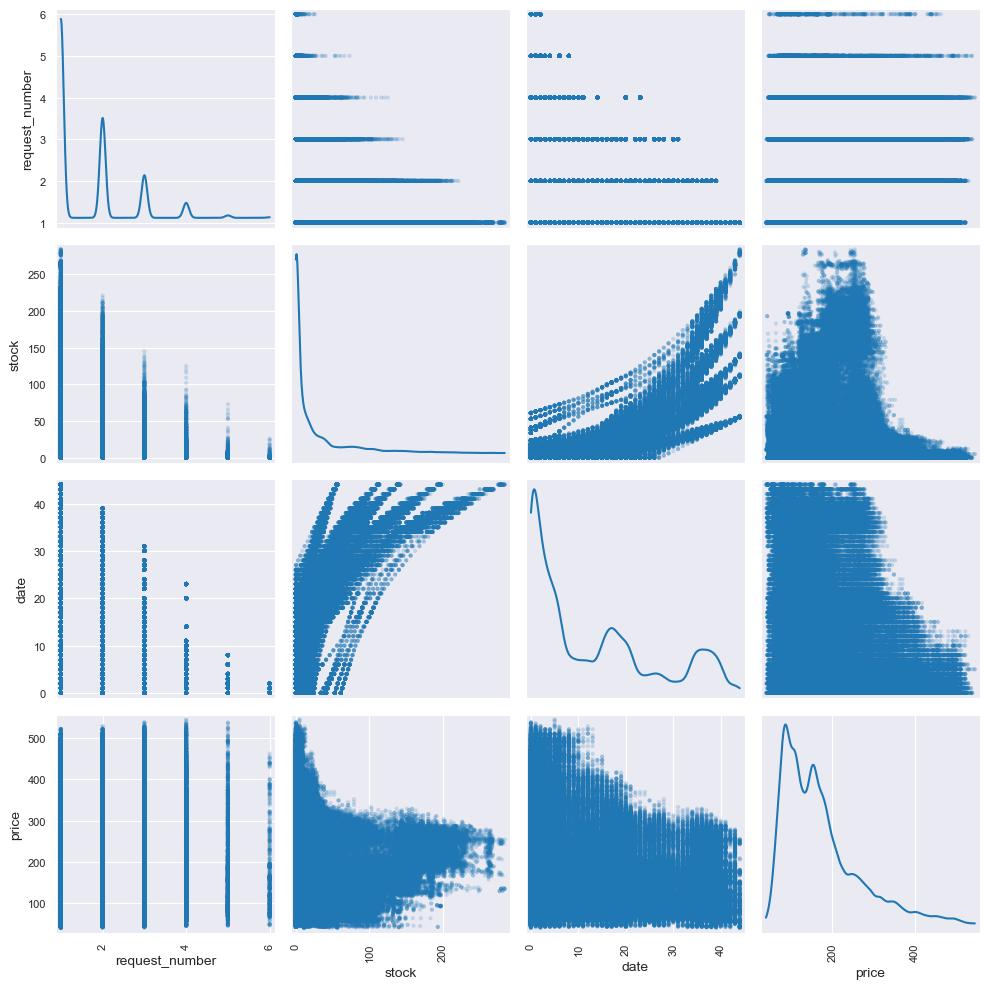

In [20]:
from pandas.plotting import scatter_matrix
scatter_matrix(data[colQT], alpha=0.2, figsize=(10, 10), diagonal='kde')
plt.tight_layout()
plt.show()

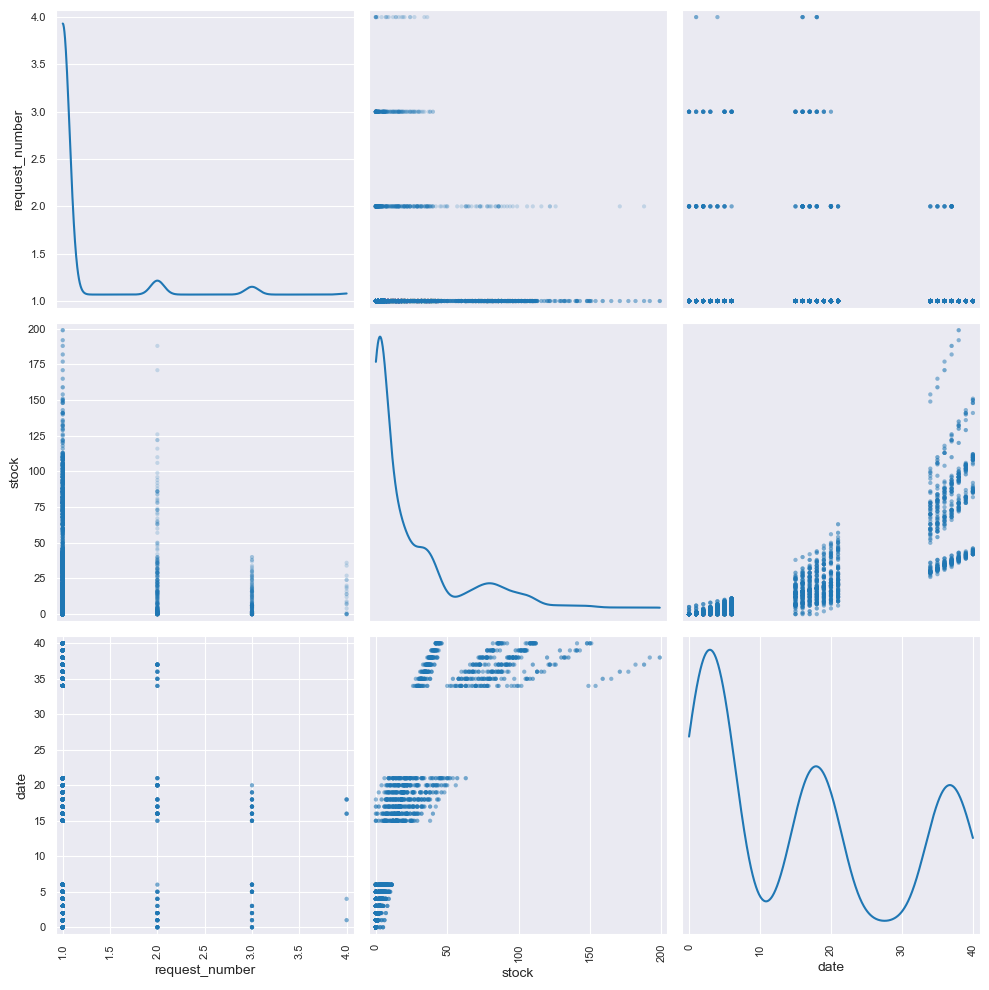

In [18]:
scatter_matrix(data_test[colQT], alpha=0.2, figsize=(10, 10), diagonal='kde')
plt.tight_layout()
plt.show()

In [95]:
dataDum = pd.get_dummies(data[['city','language','mobile','hotel_id','group','brand','parking','pool','children_policy']])
del dataDum['city_amsterdam']
del dataDum['language_austrian']
del dataDum['mobile_0']
del dataDum['hotel_id_0']
del dataDum['group_Accar Hotels']
del dataDum['brand_8 Premium']
del dataDum['parking_0']
del dataDum['pool_0']
del dataDum['children_policy_0']

# on Test Set

dataDum_test = pd.get_dummies(data_test[['city','language','mobile','hotel_id','group','brand','parking','pool','children_policy']])
del dataDum_test['city_amsterdam']
del dataDum_test['language_austrian']
del dataDum_test['mobile_0']
del dataDum_test['hotel_id_0']
del dataDum_test['group_Accar Hotels']
del dataDum_test['brand_8 Premium']
del dataDum_test['parking_0']
del dataDum_test['pool_0']
del dataDum_test['children_policy_0']

In [96]:
for i in dataDum.columns:
    if i not in dataDum_test.columns:
        dataDum_test[i] = 0

C:\Users\kc6429\AppData\Local\Temp\ipykernel_11940\677743640.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataDum_test[i] = 0
C:\Users\kc6429\AppData\Local\Temp\ipykernel_11940\677743640.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataDum_test[i] = 0
C:\Users\kc6429\AppData\Local\Temp\ipykernel_11940\677743640.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(a

C:\Users\kc6429\AppData\Local\Temp\ipykernel_11940\677743640.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataDum_test[i] = 0
C:\Users\kc6429\AppData\Local\Temp\ipykernel_11940\677743640.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataDum_test[i] = 0
C:\Users\kc6429\AppData\Local\Temp\ipykernel_11940\677743640.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(a

C:\Users\kc6429\AppData\Local\Temp\ipykernel_11940\677743640.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataDum_test[i] = 0
C:\Users\kc6429\AppData\Local\Temp\ipykernel_11940\677743640.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataDum_test[i] = 0
C:\Users\kc6429\AppData\Local\Temp\ipykernel_11940\677743640.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(a

In [97]:
dataDum_test = dataDum_test[dataDum.columns]

In [98]:
dataDum_test.head()

,city_copenhagen,city_madrid,city_paris,city_rome,city_sofia,city_valletta,city_vienna,city_vilnius,language_belgian,language_bulgarian,...,brand_Morriot,brand_Navatel,brand_Quadrupletree,brand_Royal Lotus,brand_Safitel,brand_Tripletree,parking_1,pool_1,children_policy_1,children_policy_2
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0


In [99]:
dataDum.head()

,city_copenhagen,city_madrid,city_paris,city_rome,city_sofia,city_valletta,city_vienna,city_vilnius,language_belgian,language_bulgarian,...,brand_Morriot,brand_Navatel,brand_Quadrupletree,brand_Royal Lotus,brand_Safitel,brand_Tripletree,parking_1,pool_1,children_policy_1,children_policy_2
0,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [100]:
# First work without order request 
# del colQT[0]

In [101]:
dataQt = data[colQT[:-1]]
dataQt_test = data_test[colQT[:-1]]

In [102]:
df = pd.concat([dataDum,dataQt],axis=1)
df_test = pd.concat([dataDum_test,dataQt_test],axis=1)
df.head()

,city_copenhagen,city_madrid,city_paris,city_rome,city_sofia,city_valletta,city_vienna,city_vilnius,language_belgian,language_bulgarian,...,brand_Royal Lotus,brand_Safitel,brand_Tripletree,parking_1,pool_1,children_policy_1,children_policy_2,request_number,stock,date
0,0,0,0,0,0,1,0,0,0,1,...,0,0,0,1,0,0,0,1,10,2
1,0,0,0,0,0,1,0,0,0,1,...,0,0,0,1,0,0,0,1,49,32
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,49,32
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,5
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,64,36


In [103]:
df_test.head()

,city_copenhagen,city_madrid,city_paris,city_rome,city_sofia,city_valletta,city_vienna,city_vilnius,language_belgian,language_bulgarian,...,brand_Royal Lotus,brand_Safitel,brand_Tripletree,parking_1,pool_1,children_policy_1,children_policy_2,request_number,stock,date
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,46,21
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,2,36,18
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,44,20
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,2,36,18
4,0,0,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,3,30,16


In [104]:
# variable à expliquer réelle
if transfo :
    Y = data['SRprice']
else :
    Y = data['price']

In [105]:
# # séparation pour les tests et tunner les modèles
# X_train,X_test,Yr_train,Yr_test=train_test_split(df,Yr,test_size=.25,random_state=11) #25% pour le test_size
# submit = False

In [106]:
# séparation pour submit
X_train = df
X_test = df_test
Y_train = Y
Y_test = None
submit = True

In [107]:
# # standardisation des données
# from sklearn.preprocessing import StandardScaler  
# scaler = StandardScaler()  
# scaler.fit(X_train)  
# X_stand_train = scaler.transform(X_train)  
# # Meme transformation sur le test
# X_stand_test = scaler.transform(X_test)

# Boosting

https://xgboost.readthedocs.io/en/stable/python/python_intro.html

In [108]:
# définition des paramètres
boost = GradientBoostingRegressor()
# apprentissage
rfFit = boost.fit(X_train,Y_train)

In [109]:
if not submit:
# erreur de prédiction sur le test
    1-rfFit.score(X_test,Y_test)

In [110]:
# prédiction
y_pred = rfFit.predict(X_test)
if not submit:
    print("MSE =",mean_squared_error(y_pred,Y_test))
    print("R2 =",r2_score(Y_test,y_pred))

# Random Forest

In [ ]:
# définition des paramètres
forest = RandomForestRegressor(n_estimators=500,
                               max_depth=None,
                               min_samples_split=2, min_samples_leaf=1, 
                               max_features='auto', max_leaf_nodes=None,
                               bootstrap=True, oob_score=True)
# apprentissage
rfFit = forest.fit(X_train,Y_train)
print(1-rfFit.oob_score_)

In [ ]:
param=[{"max_features":list(range(2,10,1))}]
rf= GridSearchCV(RandomForestRegressor(n_estimators=100),param,cv=5,n_jobs=-1)
rfOpt=rf.fit(X_train, Y_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_,rfOpt.best_params_))

In [ ]:
if not submit:
# erreur de prévision sur le test
    1-rfOpt.score(X_test,Y_test)

In [ ]:
# prévision
y_pred = rfOpt.predict(X_test)
if not submit :
    print("MSE=",mean_squared_error(y_pred,Y_test))
    print("R2=",r2_score(Y_test,y_pred))

# Export predictions

In [203]:
y_pred

[108,
 112,
 108,
 112,
 112,
 112,
 115,
 121,
 121,
 119,
 119,
 119,
 110,
 108,
 112,
 115,
 115,
 112,
 115,
 115,
 121,
 119,
 108,
 108,
 121,
 115,
 108,
 110,
 110,
 132,
 154,
 132,
 154,
 154,
 154,
 145,
 167,
 167,
 163,
 163,
 163,
 151,
 137,
 154,
 145,
 145,
 154,
 145,
 129,
 167,
 163,
 137,
 137,
 167,
 145,
 137,
 140,
 140,
 51,
 66,
 51,
 66,
 66,
 66,
 54,
 71,
 71,
 70,
 70,
 70,
 64,
 51,
 66,
 54,
 54,
 66,
 54,
 54,
 71,
 70,
 51,
 51,
 71,
 54,
 51,
 52,
 52,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 54,
 55,
 51,
 55,
 51,
 51,
 51,
 54,
 55,
 53,
 51,
 51,
 54,
 54,
 51,
 51,
 51,
 54,
 55,
 51,
 51,
 51,
 51,
 51,
 55,
 53,
 55,
 55,
 55,
 54,
 55,
 51,
 51,
 54,
 55,
 51,
 54,
 51,
 51,
 51,
 51,
 51,
 53,
 55,
 55,
 53,
 51,
 51,
 54,
 51,
 54,
 54,
 51,
 54,
 55,
 54,
 55,
 51,
 55,
 55,
 55,
 51,
 55,
 51,
 51,
 54,
 51,
 51,
 55,
 54,
 51,
 54,
 54,
 51,
 51,
 51,
 54,
 55,
 51,
 51,
 51,
 51,
 177,
 177,
 177,
 177,
 177,
 177,
 177,
 179,
 192,
 177,
 1

In [205]:
# save
if transfo:
    y_pred = y_pred**3
if submit :
    sub = pd.DataFrame(y_pred+10)
    sub.to_csv('copy2.csv',index=True, header=['price'], index_label = 'index')

<AxesSubplot:ylabel='Count'>

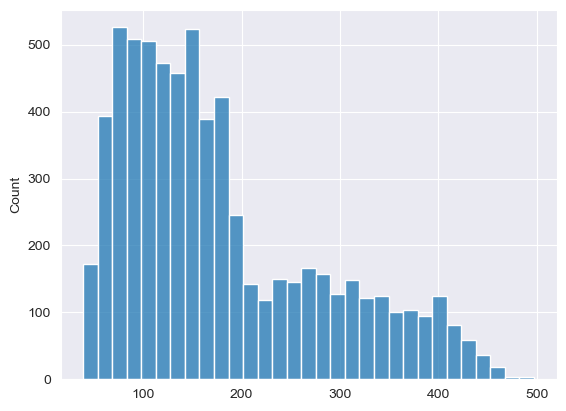

In [206]:
sns.histplot(y_pred)

In [ ]:
data_test['price'] = y_pred

In [ ]:
data_test